# Explore the Yelp Reviews Sentiment Dataset  

[yelp_reviews_full dataset on huggingface](https://huggingface.co/datasets/yelp_review_full)

Questions we seek to answer:  
1. How many training and test samples are there?
2. How many class labels are there? 
3. What do the class labels mean?
4. Do we have balanced classes?
5. What's the distribution of text lengths we will be training on?
6. How diverse is the vocabulary in these yelp reviews? 

In [2]:
%%capture
!pip install datasets

In [3]:
from datasets import load_dataset

In [4]:
# load this dataset from the Hugging Face Hub
dataset = load_dataset("yelp_review_full")

Found cached dataset yelp_review_full (/Users/d/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf)


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
dataset.shape, dataset.column_names

({'train': (650000, 2), 'test': (50000, 2)},
 {'train': ['label', 'text'], 'test': ['label', 'text']})

In [6]:
dataset['train'][100]["text"]

'My expectations for McDonalds are t rarely high. But for one to still fail so spectacularly...that takes something special!\\nThe cashier took my friends\'s order, then promptly ignored me. I had to force myself in front of a cashier who opened his register to wait on the person BEHIND me. I waited over five minutes for a gigantic order that included precisely one kid\'s meal. After watching two people who ordered after me be handed their food, I asked where mine was. The manager started yelling at the cashiers for \\"serving off their orders\\" when they didn\'t have their food. But neither cashier was anywhere near those controls, and the manager was the one serving food to customers and clearing the boards.\\nThe manager was rude when giving me my order. She didn\'t make sure that I had everything ON MY RECEIPT, and never even had the decency to apologize that I felt I was getting poor service.\\nI\'ve eaten at various McDonalds restaurants for over 30 years. I\'ve worked at more t

In [8]:
with open("../../data/adhoc/mcdonalds_fail.txt", "w") as f:
    f.write(dataset['train'][100]["text"])

In [9]:
import pandas as pd

# Convert to pandas dataframe
df = dataset['train'].to_pandas()

In [10]:
df.head()

,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...


## Do we have balanced classes?

What is the distribution of the labels? 

Balanced classes are an important consideration because if the classes are imbalanced, the model will try to cheat and simply predict the class it is more likely to see (a.k.a. the model will be biased towards the majority class). 

In [11]:
df['label'].value_counts() # 0 = 1 star, 1 = 2 star, 2 = 3 star, 3 = 4 star, 4 = 5 star

label
4    130000
1    130000
3    130000
0    130000
2    130000
Name: count, dtype: int64

## What's the distribution of text lengths we will be training on?

In [12]:
!pip install matplotlib

<Axes: >

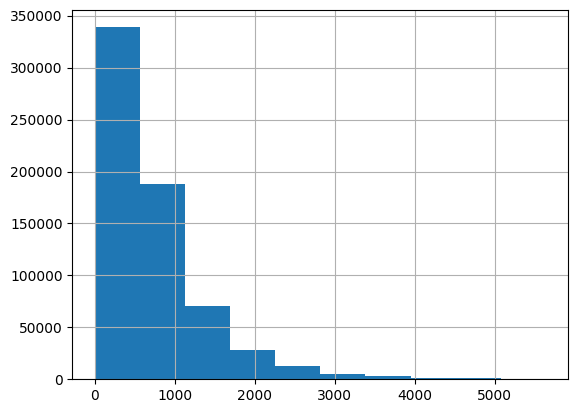

In [13]:
from matplotlib import pyplot as plt
df['text'].str.len().hist()

## Are the distribution of text lengths the same for different classes? 

Do you think people tend to write longer good reviews or bad reviews?

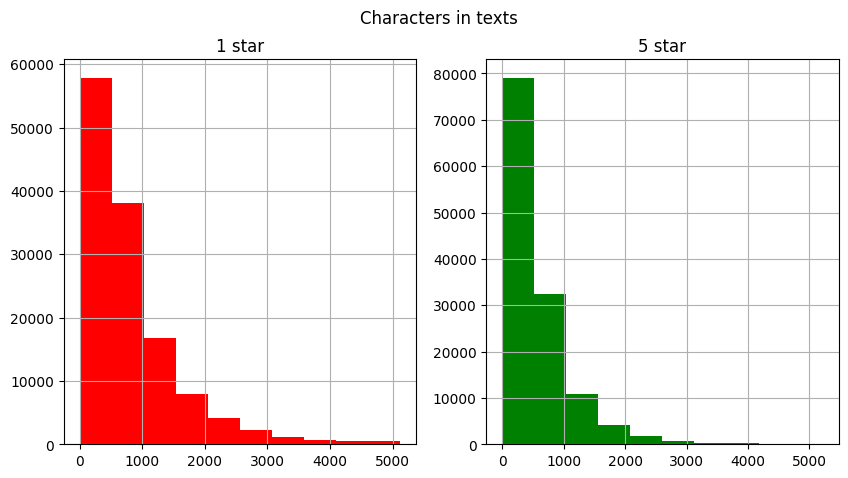

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
df[df['label'] == 0]['text'].str.len().hist(ax=ax[0], color='red')
ax[0].set_title('1 star')
df[df['label'] == 4]['text'].str.len().hist(ax=ax[1], color='green')
ax[1].set_title('5 star')
fig.suptitle('Characters in texts')
plt.show()


In [15]:
# describe the length of text for each label
for i in [0, 4]:
    print(f"{i+1}-star reviews \n {df[df['label'] == i]['text'].str.len().describe()}")

1-star reviews 
 count    130000.000000
mean        815.307762
std         761.491098
min           1.000000
25%         308.000000
50%         581.000000
75%        1056.000000
max        5115.000000
Name: text, dtype: float64
5-star reviews 
 count    130000.000000
mean        579.838346
std         560.303570
min           1.000000
25%         220.000000
50%         408.000000
75%         741.000000
max        5214.000000
Name: text, dtype: float64


## How much of their review do we need to read to understand their sentiment?
Let's take a look at the vocab of the one star reviews.

In [16]:
df_1star = df[df['label'] == 0]

In [17]:
df_1star.head()

,label,text
4,0,I don't know what Dr. Goldberg was like before...
7,0,I'm writing this review to give you a heads up...
10,0,Owning a driving range inside the city limits ...
11,0,This place is absolute garbage... Half of the...
24,0,"Used to go there for tires, brakes, etc. Thei..."


In [18]:
sample = df_1star['text'].values[-1]
len(sample.split("."))

36

In [22]:
with open("../../data/adhoc/switcharoo_review.txt", "w") as f:
    f.write(sample)

In [19]:
sample.split(".")[:5]

['I have been using this company for 11 months',
 '  Ryan would come out every other week and do what he needed to be done',
 ' Very little was required as I have desert landscaping and pretty much maintained it myself',
 '  Just needed blowing and general light cleanup',
 '  Ryan was very thorough']

In [20]:
sample.split(".")[-5:]

['',
 '',
 'NOT EVEN A CALL WHEN THEY CANNOT COME',
 '   \\n\\nSORRY RYAN, I WILL TAKE MY BUSINESS ELSEWHERE',
 '  AS A BUSINESS OWNER, YOU SHOULD KNOW BETTER!!!!']

In the above example, we see that the model could easily be confused if it's not fed the entire review. 

We also notice that the use of all caps is an effective way to express the intensity of sentiment. So let's be careful to retain this info so the model can learn from it. 

### Optional Exercise: Explore the data and note any interesting observations we should consider when building our model  

Suggestions:
- Besides exclamation points and all caps, what are other signatures of a 1-star review? Or a 5-star review?
- Do the 1-star reviews have a unique vocabulary? What about the 5-star reviews?
- How diverse is the vocabulary in these yelp reviews?


### Optional Exercise: Play with making word clouds for each star rating

In [25]:
!pip install wordcloud

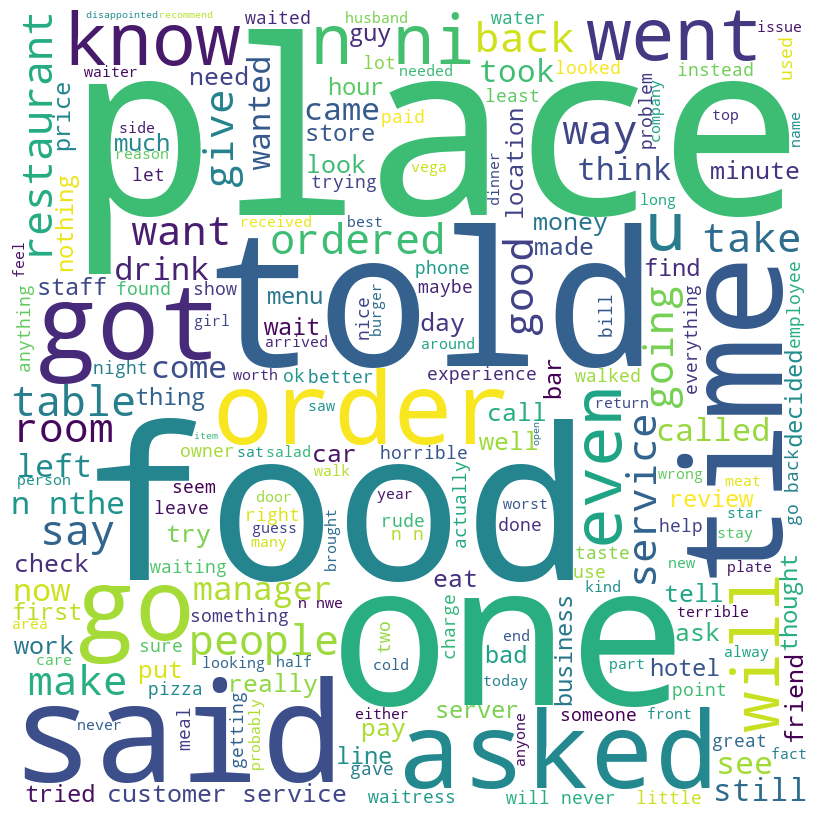

In [30]:
from wordcloud import WordCloud, STOPWORDS

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for review in df_1star.text:

	# split the value
	tokens = review.split()
	
	# Converts each token into lowercase
	for i in range(len(tokens)):
		tokens[i] = tokens[i].lower()
	
	comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
				background_color ='white',
				stopwords = stopwords,
				min_font_size = 10).generate(comment_words)

# plot the WordCloud image					
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()
